<a href="https://colab.research.google.com/github/o-fugi/FURSPColexification/blob/main/code/Evaluate_Concreteness_and_Similarity_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import re
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ColabFiles/

Mounted at /content/drive/
/content/drive/MyDrive/ColabFiles


In [55]:
# import clics and frequency/concreteness data

clics_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/clics-colexification-data.csv')
source_vars_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/source_vars_df.csv') 
sem_shift_df = pd.read_csv('/content/drive/MyDrive/ColabFiles/filtered_dat_sem_shift.csv')

In [4]:
# install sentence-trasnformers
%%capture
! pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('whaleloops/phrase-bert')

In [5]:
# define how we map a sense to concreteness

skip_words = {'the', 'an', 'a', 'of','in', 'it', 'to', 'for', 'on', 'in'} # don't factor these into concreteness

# take all words in the sense and and average concreteness
def senseToConc(s):
  s = s.lower()
  for i in "(),/":
    s = s.replace(i, "")
  phrases = re.split(' ', s)
  total_conc = 0
  conc_data = 0
  for p in phrases:
    if p in skip_words:
      continue
    try:
      conc = source_vars_df[source_vars_df['Word']==p]['Conc'].values[0]
      if not np.isnan(conc):
        total_conc += conc
        conc_data += 1
    except:
      pass
  if conc_data == 0:
    total_conc = np.nan
  else:
    total_conc /= conc_data
  return total_conc

In [45]:
# pickle load dictionary for conreteness and embeddings to save like 7 minutes of loading 
import pickle

conc_dic = pickle.load(open('conc_dic.p', 'rb'))
vec_dic = pickle.load(open('vec_dic.p', 'rb'))

In [7]:
# dictionary for concreteness and embeddings
conc_dic = {} # This will be a dictionary that easily allows us to access the concreteness for all of our senses, saving time. 
vec_dic = {} # This will be a dictionary that easily allows us to access the embedding for all of our senses, saving time. 
error_senses = set()  # This represents the set of senses for which there was a problem converting them to embeddings. 

for i in range(len(clics_df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = clics_df.iloc[i]
  x = row["Concepticon_Gloss.xo"]
  y = row["Concepticon_Gloss.yo"]

  try:   
    if x not in vec_dic:
      xvec = np.array(model.encode(x))
      vec_dic[x] = xvec
  except:
    error_senses.add(x)

  try:  
    if y not in vec_dic:
      yvec = np.array(model.encode(y))
      vec_dic[y] = yvec
  except: 
    error_senses.add(y)

  if x not in conc_dic:
    x_conc = senseToConc(x)
    if not np.isnan(x_conc):
      conc_dic[x] = x_conc
    else:
      error_senses.add(x)

  if y not in conc_dic:
    y_conc = senseToConc(y)
    if not np.isnan(y_conc):
      conc_dic[y] = y_conc
    else:
      error_senses.add(y)

error_senses = list(error_senses) # List of all senses that could not be converted to embeddings. Should be empty right now with phrase BERT
senses = list(vec_dic.keys()) # List of all concepts

sense_indices = {senses[i]:i for i in range(len(senses))} # sense_indices is a dictionary where its keys are senses and its values are the indices for which the senses appear in our list of senses.

In [23]:
# get p(s_i)

conc_df = pd.DataFrame.from_dict(conc_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'conc'})
all_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on='Concepticon_Gloss.xo',right_on='Word', how='left'), [clics_df, conc_df])
all_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on='Concepticon_Gloss.yo',right_on='Word', how='left'), [all_vars_df, conc_df])
all_vars_df['prior'] = all_vars_df[['conc_x', 'conc_y']].max(axis=1)

In [24]:
# get f(s_i, s_j)

def getEmbedding(s):
  return vec_dic[s]

def getSim(vec):
  x = vec[0]
  y = vec[1]
  return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

all_vars_df['v1'] = all_vars_df['Concepticon_Gloss.xo'].apply(getEmbedding)
all_vars_df['v2'] = all_vars_df['Concepticon_Gloss.yo'].apply(getEmbedding)
all_vars_df['sim'] = all_vars_df[['v1', 'v2']].apply(getSim, axis=1)

In [43]:
print('Spearman correlation for colex and similarity:', all_vars_df.corr()['sim']['colex.freq']) # verified by Cognition paper
print('Spearman correlation for colex and prior:', all_vars_df.corr()['prior']['colex.freq']) # negative ... not great

Spearman correlation for colex and similarity: 0.21034262853971106
Spearman correlation for colex and prior: -0.018099557286153457


In [37]:
# linear regression to get coefficients

filtered_vars_df = all_vars_df[~np.isnan(all_vars_df['sim']) & ~np.isnan(all_vars_df['prior'])]

filtered_vars_df['log_prior'] = np.log(filtered_vars_df['prior'])
filtered_vars_df['log_sim'] = np.log(filtered_vars_df['sim'])

X = filtered_vars_df[['prior', 'sim']].values.reshape(-1, 2)  
Y = filtered_vars_df[['colex.freq']].values.reshape(-1, 1)
lin_reg = LinearRegression().fit(X, Y)
filtered_vars_df['lin_reg_predict'] = lin_reg.predict(X)
print(lin_reg.score(X, Y))

0.04443630741887361


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

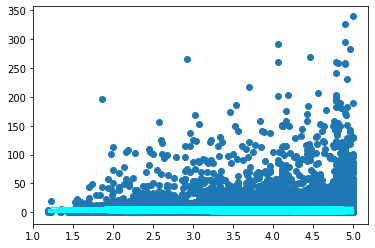

In [46]:
#@title plot showing that p(s_i) should kinda be correlated with concreteness

plt.scatter(X[:,0], Y)
plt.plot(X[:,0], lin_reg.predict(X), c='cyan')
plt.show()

# Test prior accuracy (currently 66%)

In [60]:
# filter semshift by realizations > 1 
sem_shift_df = sem_shift_df[sem_shift_df['realizations'] > 1]

In [61]:
# get priors for semshift data

# dictionary for concreteness and embeddings
conc_dic = {} # This will be a dictionary that easily allows us to access the concreteness for all of our senses, saving time. 
error_senses = set()  # This represents the set of senses for which there was a problem converting them to embeddings. 

for i in range(len(sem_shift_df)): # Here we loop through each row of our dataframe, and if we can convert a sense s to an embedding then we set vec_dic[s] = embedding
  row = sem_shift_df.iloc[i]
  x = row["meaning1"]
  y = row["meaning2"]

  if x not in conc_dic:
    x_conc = senseToConc(x)
    if not np.isnan(x_conc):
      conc_dic[x] = x_conc
    else:
      error_senses.add(x)

  if y not in conc_dic:
    y_conc = senseToConc(y)
    if not np.isnan(y_conc):
      conc_dic[y] = y_conc
    else:
      error_senses.add(y)

error_senses = list(error_senses) # List of all senses that could not be converted to embeddings. Should be empty right now with phrase BERT
senses = list(vec_dic.keys()) # List of all concepts

sense_indices = {senses[i]:i for i in range(len(senses))} # sense_indices is a dictionary where its keys are senses and its values are the indices for which the senses appear in our list of senses.

In [62]:
# test prior accuracy

# merge concreteness with shift df
conc_df = pd.DataFrame.from_dict(conc_dic, orient='index').reset_index().rename(columns={'index':'Word', 0:'conc'})
all_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning1',right_on='Word', how='left'), [sem_shift_df, conc_df])
all_vars_df = reduce(lambda  left,right: pd.merge(left,right,left_on='meaning2',right_on='Word', how='left'), [all_vars_df, conc_df])

# calculate ratio and find accuracy
all_vars_df['ratio'] = all_vars_df['conc_x'] / all_vars_df['conc_y']
all_vars_df['ratio_accurate'] = all_vars_df['ratio'] > 1
print(all_vars_df['ratio_accurate'].value_counts())
print("accuracy: ", all_vars_df['ratio_accurate'].value_counts()[True] / len(all_vars_df))

True     988
False    502
Name: ratio_accurate, dtype: int64
accuracy:  0.6630872483221476
